In [1]:
import numpy as np

fileNames = np.loadtxt('train_diagnose.txt', dtype=np.str, delimiter='\t')
# np.random.shuffle(fileNames)

testNames = np.loadtxt('test_diagnose.txt', dtype=np.str, delimiter='\t')
# np.random.shuffle(testNames)

['0' '0' '0' ... '1' '1' '1']


In [2]:
import cv2
import collections
data = []
labels = []
for i in range(len(fileNames)):
    label = fileNames[i][1]
    image = cv2.imread(fileNames[i][0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    data.append(image)
    labels.append(int(label))

data = np.array(data)
labels = np.array(labels)

t_data = []
t_labels = []
for i in range(len(testNames)):
    label = testNames[i][1]
    image = cv2.imread(testNames[i][0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    t_data.append(image)
    t_labels.append(int(label))

t_data = np.array(t_data)
t_labels = np.array(t_labels)

collections.Counter(t_labels)
print(labels)

<ipython-input-2-6aed46122b67>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(data)
<ipython-input-2-6aed46122b67>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_data = np.array(t_data)


[0 0 0 ... 1 1 1]


In [3]:
import collections
print(collections.Counter(t_labels))

def label2d(_labels):
    _labels_2d = np.ndarray(shape=(len(_labels), 1))
    for j in range(len(_labels)):
        _labels_2d[j,:] = _labels[j]
    # print(_labels_2d)
    return _labels_2d

labels_2d = label2d(labels)
t_labels_2d = label2d(t_labels)
print(labels_2d)

Counter({1: 390, 0: 234})
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]


In [4]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
labels_trans = encoder.fit_transform(labels_2d)
t_labels_trans = encoder.fit_transform(t_labels_2d)
print(labels_trans)
print("Total classes: ", labels_trans.ndim)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Total classes:  2


In [5]:
from torchvision.transforms import transforms
# define transforms
train_transform = transforms.Compose(
    [transforms.ToPILImage(),
	 transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485], std=[0.229])
    ])
val_transform = transforms.Compose(
    [transforms.ToPILImage(),
	 transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485], std=[0.229])
    ])

In [6]:
from sklearn.model_selection import train_test_split
# 可改变，尝试使用给出的Eval.txt和Test.txt
# divide the data into train, validation, and test set
(X, x_val , Y, y_val) = train_test_split(data, labels_trans,
                                                    test_size=0.2,
                                                    stratify=labels,
                                                    random_state=42)

(x_train, x_test, y_train, y_test) = train_test_split(X, Y,
                                                    test_size=0.25,
                                                    random_state=42)
(x_ftest, y_ftest) = (t_data, t_labels_trans)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")
print(type(x_train))
print(y_val)

x_train examples: (3138,)
x_test examples: (1047,)
x_val examples: (1047,)
<class 'numpy.ndarray'>
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [7]:
import matplotlib.pyplot as plt
import matplotlib
import joblib
import cv2
import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

matplotlib.style.use('ggplot')

'''SEED Everything'''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True # keep True if all the input have same size.
SEED=42
seed_everything(SEED=SEED)
'''SEED Everything'''

'SEED Everything'

In [8]:
if torch.cuda.is_available():
    print('using cuda')

epochs = 40
BATCH_SIZE = 32

using cuda


In [9]:
from torch.utils.data import DataLoader, Dataset
# custom dataset
class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        data = self.X[i][:]

        if self.transforms:
            data = self.transforms(data)

        if self.y is not None:
            return data, self.y[i]
        else:
            return data

train_data = ImageDataset(x_train, y_train, train_transform)
val_data = ImageDataset(x_val, y_val, val_transform)
# test_data = ImageDataset(x_test, y_test, val_transform)
# print(x_test)
# print(val_transform)
test_data = ImageDataset(x_test, y_test, val_transform)
final_test_data = ImageDataset(x_ftest, y_ftest, val_transform)

In [10]:
# dataloaders
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
import torchvision
# the resnet34 model
class MyResNet(nn.Module):
    def __init__(self, in_channels=1):
        super(MyResNet, self).__init__()
        # bring resnet
        self.model = torchvision.models.resnet34(pretrained=True)
        for params in self.model.parameters():
            params.requires_grad = False

        layers_resnet = nn.Sequential(collections.OrderedDict([
                ('fc1', nn.Linear(512, 256)),
                ('activation1', nn.ReLU()),
                ('fc2', nn.Linear(256, 128)),
                ('activation2', nn.ReLU()),
                ('fc3', nn.Linear(128, 2)),
                ('out', nn.Sigmoid())
            ]))

        self.model.fc = layers_resnet
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyResNet().to(device)
print(model)

MyResNet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [12]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [13]:
# training function
def fit(model, dataloader):
    print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device=device, dtype=torch.int32)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, torch.max(target, 1)[1])
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        loss.backward()
        optimizer.step()

    loss = running_loss/len(dataloader.dataset)
    accuracy = 100. * running_correct/len(dataloader.dataset)

    print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")

    return loss, accuracy

In [14]:
#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device=device, dtype=torch.int32)
            outputs = model(data)
            loss = criterion(outputs, torch.max(target, 1)[1])
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_correct += (preds == torch.max(target, 1)[1]).sum().item()

        loss = running_loss/len(dataloader.dataset)
        accuracy = 100. * running_correct/len(dataloader.dataset)
        print(f'Val Loss: {loss:.4f}, Val Acc: {accuracy:.2f}')

        return loss, accuracy

In [15]:
import monai
def test(model, dataloader):
    _correct = 0
    _total = 0
    with open('result_raw.txt', 'w') as out_file:
        with torch.no_grad():
            for data in dataloader:
                # print(data[1])
                inputs, target = data[0].to(device), data[1].to(device=device, dtype=torch.int32)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                print(predicted)
                # print()
                out_file.write(str(predicted))
                out_file.write('\n')
                _total += target.size(0)
                _correct += (predicted == torch.max(target, 1)[1]).sum().item()

    return _correct, _total

99it [00:13,  7.48it/s]                        
33it [00:03,  8.48it/s]                        
99it [00:10,  9.07it/s]                        
33it [00:03,  9.69it/s]                        
99it [00:10,  9.20it/s]                        
33it [00:03,  9.91it/s]                        
99it [00:10,  9.28it/s]                        
33it [00:03,  9.84it/s]                        
99it [00:10,  9.17it/s]                        
33it [00:03,  9.77it/s]                        
99it [00:11,  8.89it/s]                        
33it [00:03,  9.69it/s]                        
99it [00:10,  9.15it/s]                        
33it [00:03, 10.06it/s]                        
99it [00:10,  9.00it/s]                        
33it [00:03,  9.56it/s]                        
99it [00:10,  9.15it/s]                        
33it [00:03,  9.64it/s]                        
99it [00:10,  9.20it/s]                        
33it [00:03,  9.60it/s]                        
99it [00:10,  9.08it/s]                 

Training on 3138 examples, validating on 1047 examples...
Epoch 1 of 40
Training
Train Loss: 0.0180, Train Acc: 74.38
Validating
Val Loss: 0.0161, Val Acc: 75.93
Epoch 2 of 40
Training
Train Loss: 0.0142, Train Acc: 88.88
Validating
Val Loss: 0.0129, Val Acc: 92.36
Epoch 3 of 40
Training
Train Loss: 0.0126, Train Acc: 92.54
Validating
Val Loss: 0.0122, Val Acc: 93.22
Epoch 4 of 40
Training
Train Loss: 0.0124, Train Acc: 92.48
Validating
Val Loss: 0.0123, Val Acc: 91.98
Epoch 5 of 40
Training
Train Loss: 0.0119, Train Acc: 94.14
Validating
Val Loss: 0.0124, Val Acc: 91.31
Epoch 6 of 40
Training
Train Loss: 0.0123, Train Acc: 93.18
Validating
Val Loss: 0.0120, Val Acc: 93.12
Epoch 7 of 40
Training
Train Loss: 0.0118, Train Acc: 94.58
Validating
Val Loss: 0.0117, Val Acc: 94.17
Epoch 8 of 40
Training
Train Loss: 0.0116, Train Acc: 94.90
Validating
Val Loss: 0.0118, Val Acc: 94.08
Epoch 9 of 40
Training
Train Loss: 0.0115, Train Acc: 94.96
Validating
Val Loss: 0.0117, Val Acc: 94.08
Epoch 

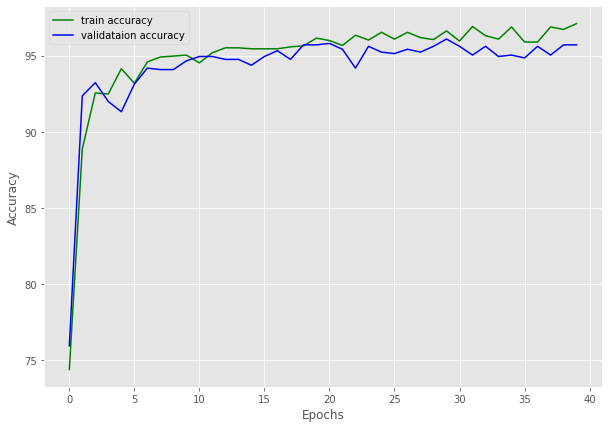

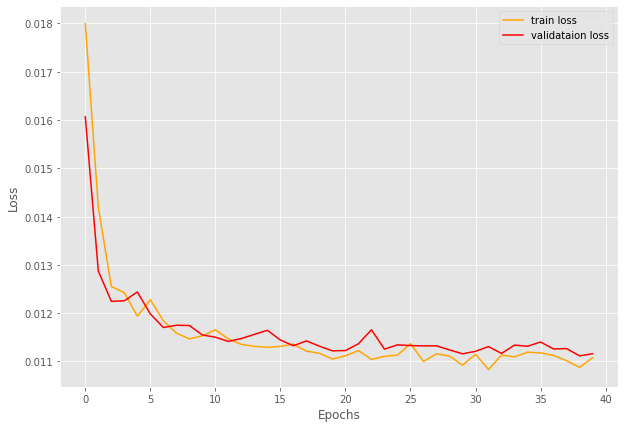

In [16]:
torch.cuda.empty_cache()
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples...")
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, valloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')

torch.save(model.state_dict(), f"resnet34_epochs{epochs}_triage.pth")

# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')

In [20]:
# save the accuracy and loss lists as pickled files
print('Pickling accuracy and loss lists...')
joblib.dump(train_accuracy, 'train_accuracy.pkl')
joblib.dump(train_loss, 'train_loss.pkl')
joblib.dump(val_accuracy, 'val_accuracy.pkl')
joblib.dump(val_loss, 'val_loss.pkl')

Pickling accuracy and loss lists...


['val_loss.pkl']

In [18]:
correct, total = test(model, testloader)
print(correct, total)
print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))
print('train.py finished running')

tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        0,

In [21]:
(x_ftest, y_ftest) = (t_data, t_labels_trans)
final_test_data = ImageDataset(x_ftest, y_ftest, val_transform)
final_testloader = DataLoader(final_test_data, batch_size=BATCH_SIZE, shuffle=False)

correct, total = test(model, final_testloader)
print(correct, total)
print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))
print('train.py finished running')

tensor([1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
tensor([0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
tensor([0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
tensor([0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1,

In [22]:
import re

pat1 = r'%s(.+?)%s' % ('\[', '\]')
p = re.compile(pat1, re.IGNORECASE)

with open('result_raw.txt', 'r') as in_file:
    with open('result.txt', 'w', encoding='utf-8', newline='\n') as out_file:
        lines = in_file.readlines()
        for line in lines:
            row = re.findall(p, line)
            if row:
                num_list = [str(x.strip()) for x in row[0].split(',')]
                for i in num_list:
                    out_file.write(i)
                    out_file.write('\n')

print('parsing done.')

parsing done.


In [23]:
train_acc = joblib.load('train_accuracy.pkl')
print(np.mean(train_acc))

94.90121096239643


In [24]:
torch.save(model, "resnet34_epochs40_diagnose_entire.pth")